# Selecting Optimal Customers for Demand Response Programs

## Introduction

The smart grid uses new technologies such as intelligent controllers, advanced software for data management, and two-way communications between power utilities and consumers to improve the efficiency, reliability and safety of the system [1]. This technology is providing new opportunities to advance the energy industry. Demand response (DR) programs are an example. 

The California PUC defines DR as "reductions, increases, or shifts in electricity consumption by customers in response to their economic signals or reliability signals" [[2]](https://www.cpuc.ca.gov/industries-and-topics/electrical-energy/electric-costs/demand-response-dr). Signals are typically either economic in nature (financial incentives, electricity prices) or related to electricity reliability (alerts that the grid is under stress). Recent DR trends involve encouraging customers to shift electricity consumption from hours of high demand relative to energy supply to hours where energy supply is plentiful relative to demand, known as _Time of Use_ (ToU). Customers who join DR programs effectively reduce their peak-hour consumption and increase their off-peak demand. Benefits to the utility include peak load shifting, improving generation capacity, and elimination of expensive spot market energy purchases. 

DR program designers need to create a customer recruitment strategy to maximize the success of the programs [1, p.50]. The growing availability of smart meter data provides utilities with the ability to segment customers based on energy usage patterns. Based on those identified segments, DR program designers can identify customers who are most likely to benefit from and opt into DR programs. This allows utilities to engage in targeted marketing, which is likely to increase positive customer response, increase customer satisfaction, and decrease utility marketing costs. 

## Project structure 

This analysis is organized as follows:

1. Data Preparation: data acquistion, preprocessing, exploration, and model prep
2. Data modeling: Cluster analysis to identify eligible customer segments
3. Data modeling: Predict (classify) new customer according to program eligibility

In [346]:
%%html
<style>
table {float:left}
</style>

#### Dependencies and notebook settings

In [345]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

height = 12
width = height * 1.6
sns.set(rc={'figure.figsize':(width, height)}, style='whitegrid', font_scale=2)

## 1. Data preparation

### Data acquisition



#### Description of Smart Meter Data

The data used in this project were collected from years 2009-10 as part of the Irish Comissions for Energy Regulation (CER) Smart Metering Project. The data includes timestamped energy usage data for over 5000 residential and commercial customers, collected on a half-hourly basis. Electricity consumption is measured in kW. Additionally, pre- and post-trial surveys for included customers are available.

In [2]:
%%time 
# Times the execution of the cell

filelist = [ # python list includes location of six files containing electricity usage data
    "~/Dev/Datasets/Utility/38_CER Electricity_Gas/electricity/File1.txt", 
    "~/Dev/Datasets/Utility/38_CER Electricity_Gas/electricity/File2.txt", 
    "~/Dev/Datasets/Utility/38_CER Electricity_Gas/electricity/File3.txt", 
    "~/Dev/Datasets/Utility/38_CER Electricity_Gas/electricity/File4.txt", 
    "~/Dev/Datasets/Utility/38_CER Electricity_Gas/electricity/File5.txt", 
    "~/Dev/Datasets/Utility/38_CER Electricity_Gas/electricity/File6.txt"
]

# Reads and concatenates each of the six files
df = pd.concat([pd.read_csv(item, header=None, sep='\s+') for item in filelist], axis=0) 

df.columns = ['meterId', 'fdCode', 'consumed'] # provides column names

CPU times: user 23.8 s, sys: 8.58 s, total: 32.4 s
Wall time: 34 s


In [3]:
print("Shape: ", df.shape) # View the shape of the data (rows, cols)
df.head() # View the first five rows of the dataset

Shape:  (157992996, 3)


,meterId,fdCode,consumed
0,1392,19503,0.140
1,1392,19504,0.138
2,1392,19505,0.140
3,1392,19506,0.145
4,1392,19507,0.145


In [4]:
df.meterId.nunique() # View the number of unique meter IDs

6435

### Preprocessing

**Note** the format of the data: 
* 157,992,996 rows by three columns
* 6,435 unique meters included
* Electricity consumed during 30-minute interval (in kWh)
* Date/time given by the following code:
    - Day code: digits 1-3 (day 1 = 1st January 2009)
    - Time code: digits 4-5 (1-48 for each 30 minutes with 1 = 00:00:00 - 00:29:59)
    
The time code value is difficult to work with. Extract `dayCode`, `timeCode` to facilitate analysis.


Additionally, questions have arisen about errors found in the dataset. ISSDA has addressed those here: https://www.ucd.ie/issda/data/commissionforenergyregulationcer/frequentlyaskedquestions/. I have corrected or removed data per the advice of the data owner.

In [5]:
# Get the first three digits of fdCode as 'dayCode'
df['dayCode'] = df.fdCode // 100 # the first three digits represents the day, beginning Jan. 1, 2009

# Get the last two digits in fdCode as 'timeCode'
df['timeCode'] = abs(df.fdCode) % 100# returns the interval (1-48)

df = df[df.timeCode<=48] # ISSDA unsure how values greater than 48 occurred; removed
# https://www.ucd.ie/issda/data/commissionforenergyregulationcer/frequentlyaskedquestions/

# The three lines that follow create a new timestamp object for each record
df['date'] = pd.to_datetime(df.dayCode, unit='D', origin=pd.Timestamp('01-01-2009')) # creates a date object corresponding to dayCode values
df['intervalEnding'] = df['timeCode'] * pd.Timedelta(30, unit='min') # creates a timedelta object corresponding to timeCode values
df['timestamp'] = df['date'] + df['intervalEnding'] # combines `date` and `intervalEnding` columns to create a timestamp value

# Cast meterId to type 'category' to take advantage of pandas category functionality
df['meterId'] = df['meterId'].astype('category')

# timeCode, date, and interval_ending are not required for future analysis
df.drop(['date', 'intervalEnding'], axis=1, inplace=True)

df.head()

,meterId,fdCode,consumed,dayCode,timeCode,timestamp
0,1392,19503,0.140,195,3,2009-07-15 01:30:00
1,1392,19504,0.138,195,4,2009-07-15 02:00:00
2,1392,19505,0.140,195,5,2009-07-15 02:30:00
3,1392,19506,0.145,195,6,2009-07-15 03:00:00
4,1392,19507,0.145,195,7,2009-07-15 03:30:00


The `pandas.info()` function provides some information about the dataset:

* The number of rows and columns, as discussed above
* Data types for each column (used for data validation)
* Total memory used: 5.0 GB

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157967994 entries, 0 to 35436011
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   meterId    category      
 1   fdCode     int64         
 2   consumed   float64       
 3   dayCode    int64         
 4   timeCode   int64         
 5   timestamp  datetime64[ns]
dtypes: category(1), datetime64[ns](1), float64(1), int64(3)
memory usage: 7.4 GB


#### View the descriptive statistics for quantitative variables

In [7]:
df.describe()

,fdCode,consumed,dayCode,timeCode
count,1.579680e+08,1.579680e+08,1.579680e+08,1.579680e+08
mean,4.591354e+04,7.056945e-01,4.588904e+02,2.450173e+01
std,1.543430e+04,1.485465e+00,1.543429e+02,1.385257e+01
min,1.950100e+04,0.000000e+00,1.950000e+02,1.000000e+00
25%,3.252500e+04,1.240000e-01,3.250000e+02,1.300000e+01
50%,4.573200e+04,2.760000e-01,4.570000e+02,2.500000e+01
75%,5.921800e+04,6.880000e-01,5.920000e+02,3.700000e+01
max,7.304800e+04,6.681500e+01,7.300000e+02,4.800000e+01


Note the following from the descriptive statistics:

* Mean usage of 0.7057 kWh and median usage of 0.2760 kWh. The usage data is likely skewed by larger values. 
* Minimum usage value of 0 kWh; were there periods of no usage from some individuals? Do we have bad data? Perhaps something to explore further.
* Maximum usage value of 66.8150 kWh, substantially larger than the average values (which are less than one kWh). 

#### View the distribution of usage with histogram and boxplot

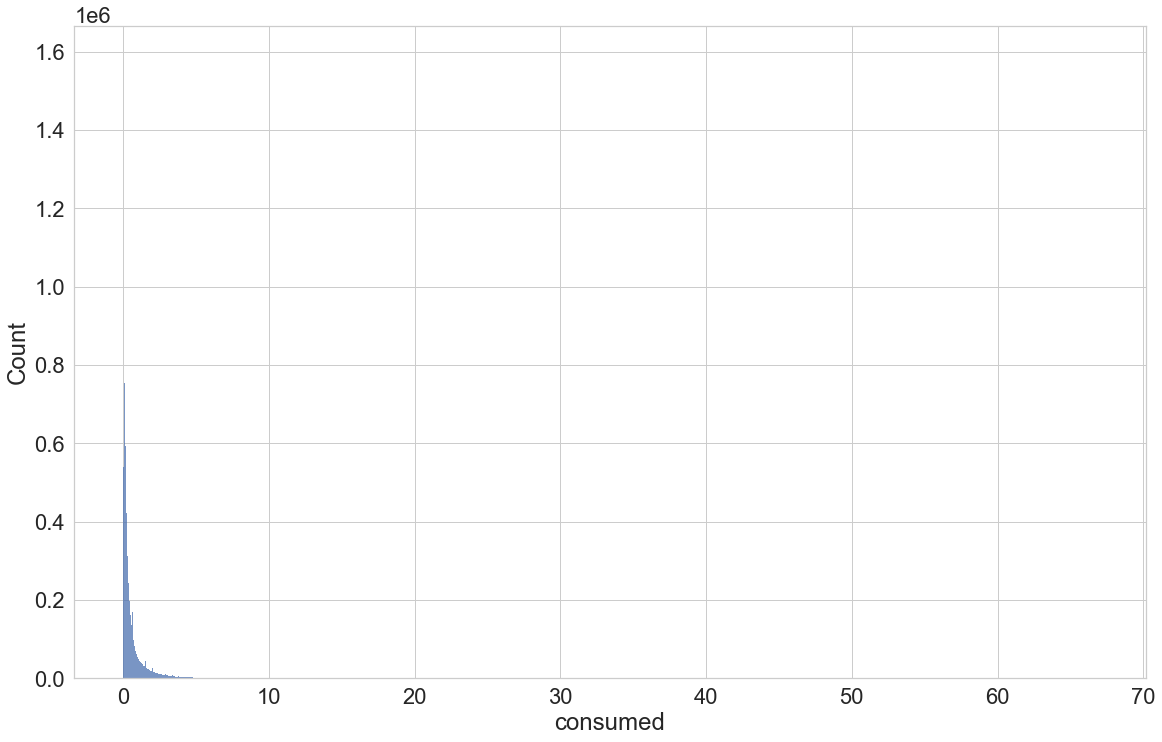

CPU times: user 58.2 s, sys: 7.26 s, total: 1min 5s
Wall time: 1min 6s


In [8]:
%%time
sns.histplot(data=df, x='consumed')
plt.show()

Histogram indicates that nearly all values are at or near zero, but at least a small number of usage values exist greater than 60.

CPU times: user 6.29 s, sys: 2.55 s, total: 8.84 s
Wall time: 8.84 s


<AxesSubplot:xlabel='consumed'>

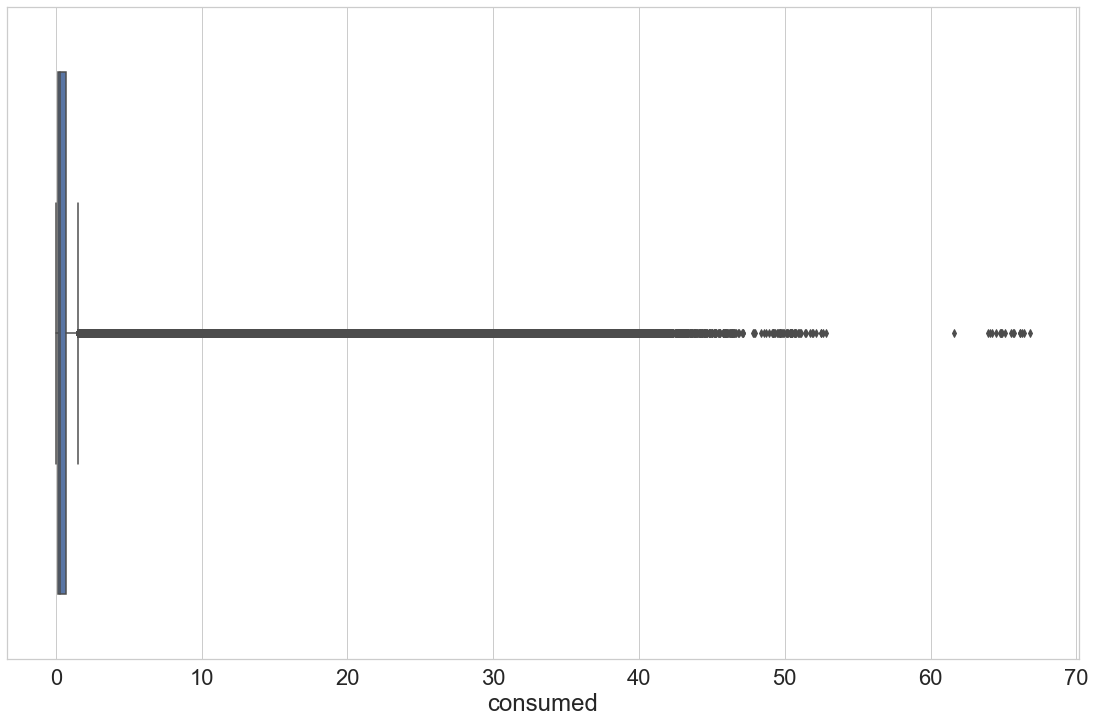

In [9]:
%%time
sns.boxplot(data=df, x='consumed')

We know that the data set includes both residential and commercial customers. Let's view the distribution with the outliers removed. Outliers here defined as records with `usage` > 1.5 * the interquartile range.

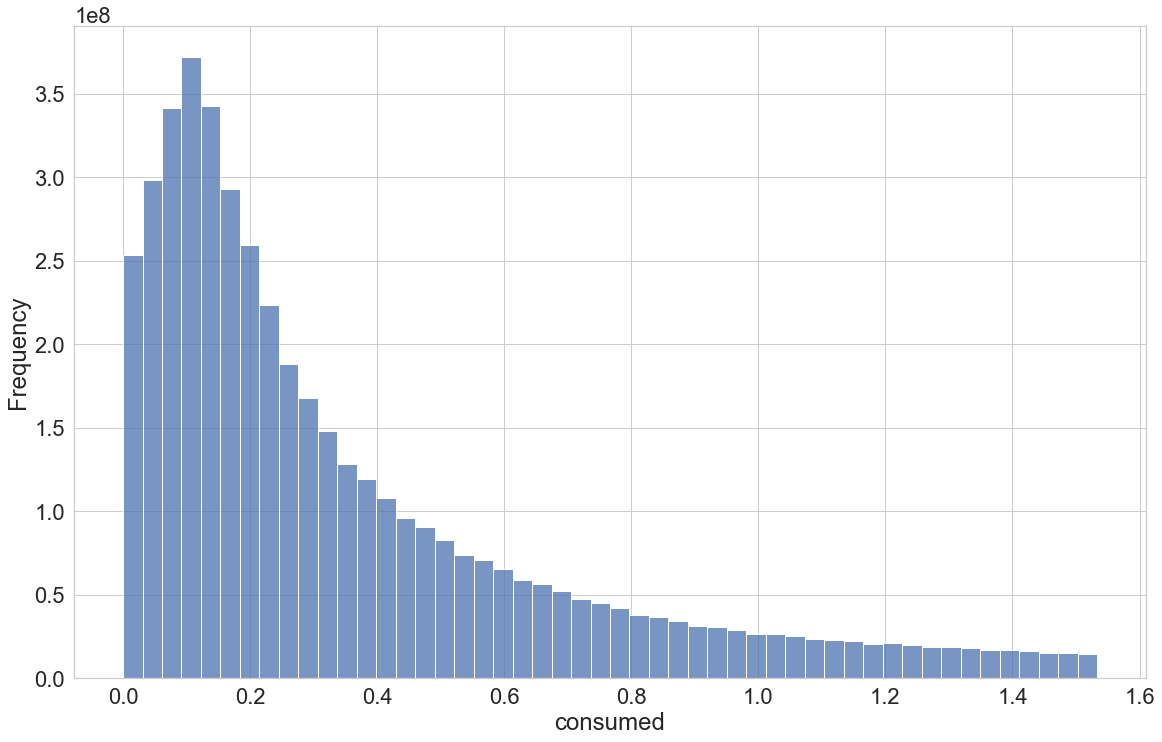

CPU times: user 24.7 s, sys: 22.9 s, total: 47.6 s
Wall time: 52.4 s


In [10]:
%%time

quantiles = df['consumed'].quantile([0.25, 0.75])
q1 = quantiles.values[0]
q3 = quantiles.values[1]
iqr = q3 - q1

sns.histplot(data=df[df.consumed <= (q3 + 1.5*iqr)], x='consumed', bins=50, stat='frequency')
plt.show()

CPU times: user 13.3 s, sys: 18.4 s, total: 31.6 s
Wall time: 32.5 s


<AxesSubplot:xlabel='consumed'>

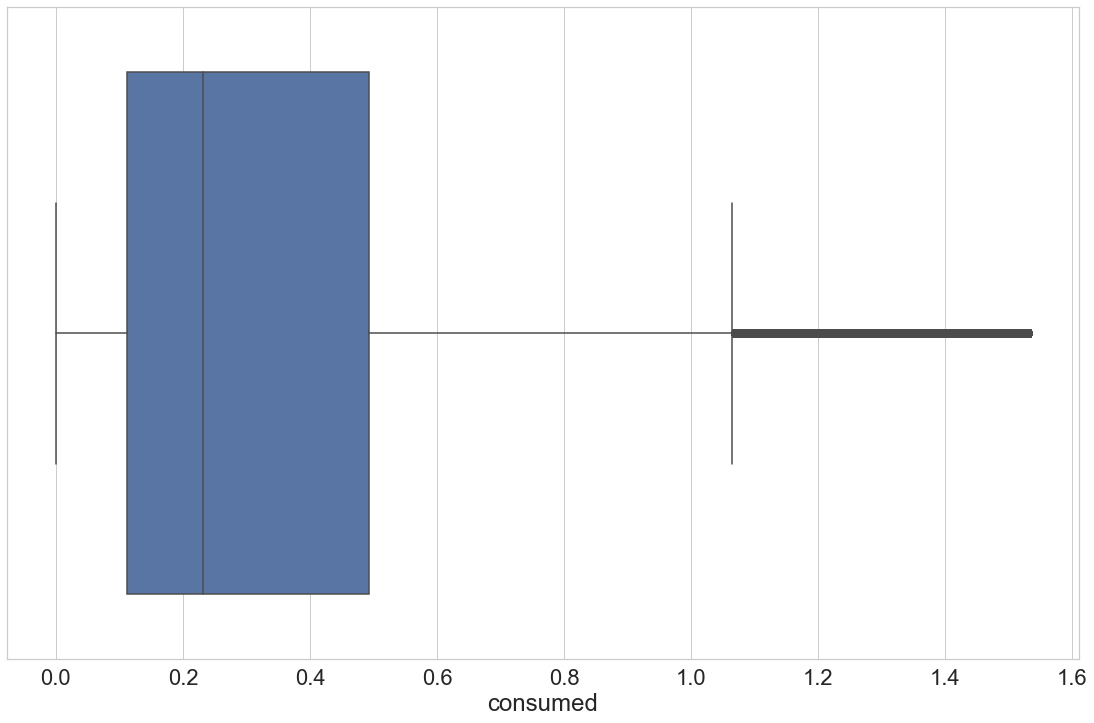

In [11]:
%%time
sns.boxplot(data=df[df.consumed <= (q3 + 1.5*iqr)], x='consumed')

The histogram and boxplot shows that the vast majority of observations have a usage value between 0 and 1, with a large number of positive outliers.

#### Missing values

Verify that there are not records with missing or empty values.

In [22]:
%%time
df.isna().sum()

CPU times: user 1.16 s, sys: 558 ms, total: 1.71 s
Wall time: 1.72 s


meterId      0
fdCode       0
consumed     0
dayCode      0
timeCode     0
timestamp    0
dtype: int64

#### Duplicate records
This process uses the `pandas.duplicated()` function to ensure records are not duplicated across the multiple available files. In the case of duplicate records, the first recorded consumption values are retained.

In [14]:
%%time
df = df[~df.duplicated(subset=['meterId','timestamp'])]

CPU times: user 21.7 s, sys: 18.4 s, total: 40.1 s
Wall time: 46.3 s


#### Filter out weekends
The analysis focuses on weekdays, which allows for a focus on stable electricity usage patterns from customers. 

In [16]:
%%time
df = df[df.timestamp.dt.dayofweek<5]

CPU times: user 10.9 s, sys: 12.8 s, total: 23.7 s
Wall time: 28 s


#### Calculate the mean for every 30 minute period
Aggregate by customer ID, then calculate the mean usage for every 30-minute interval. The result is a new DataFrame: one row per customer, 48 columns with values equal to the per customer mean usage. This allows us to create a half-hourly load profile.

In [44]:
%%time

# Get the mean consumption across readings (30-min intervals) by meterId
df_avg = df.groupby(['meterId',  'timeCode'])['consumed'].mean()

# Unstack: the 2nd index becomes the header
df_avg = df_avg.unstack(level=-1)

# prepend "interval_" to each interval in the timeCode column (index)
# df_avg = df_avg.add_prefix("interval_")

print(df_avg.shape)
df_avg.head()

(6435, 48)
CPU times: user 6.08 s, sys: 3.6 s, total: 9.69 s
Wall time: 10.2 s


timeCode,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
meterId,,,,,,,,,,,,,,,,,,,,,
1000,0.100097,0.067534,0.055955,0.058815,0.053645,0.053076,0.052778,0.052909,0.054107,0.050240,...,0.503107,0.454961,0.433512,0.432728,0.363193,0.347029,0.333530,0.284107,0.222013,0.166257
1001,0.200057,0.202846,0.198139,0.194760,0.197371,0.194232,0.190773,0.193705,0.199922,0.191619,...,0.195752,0.194196,0.203371,0.198708,0.198410,0.202843,0.201877,0.201170,0.195689,0.188851
1002,0.188436,0.130110,0.096804,0.083909,0.075149,0.072559,0.071473,0.072005,0.068862,0.072449,...,0.274227,0.294762,0.319778,0.336935,0.364621,0.363253,0.367240,0.363762,0.348097,0.281751
1003,0.567961,0.536076,0.499257,0.447995,0.428689,0.404285,0.382198,0.365094,0.384029,0.484266,...,1.056833,0.960867,0.888554,0.864486,0.856710,0.829423,0.818402,0.742366,0.678543,0.615783
1004,1.001149,0.878026,0.765110,0.673648,0.611713,0.556530,0.501992,0.449695,0.417781,0.385804,...,2.195723,2.160961,1.937637,1.919269,1.848953,1.849410,1.706154,1.550078,1.278820,1.135233


#### Normalization
Calculate the percentage of electricity consumed every 30 minutes over a period of 24 hours. 

In [96]:
usage_prop = df_avg.div(df_avg.sum(axis=1), axis=0)
usage_prop.dropna(inplace=True)
usage_prop.head()

timeCode,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
meterId,,,,,,,,,,,,,,,,,,,,,
1000,0.009831,0.006633,0.005496,0.005777,0.005269,0.005213,0.005184,0.005197,0.005314,0.004935,...,0.049414,0.044685,0.042579,0.042502,0.035672,0.034085,0.032759,0.027904,0.021806,0.016329
1001,0.021131,0.021425,0.020928,0.020571,0.020847,0.020516,0.020150,0.020460,0.021116,0.020240,...,0.020676,0.020512,0.021481,0.020988,0.020957,0.021425,0.021323,0.021248,0.020669,0.019947
1002,0.018452,0.012740,0.009479,0.008216,0.007359,0.007105,0.006999,0.007051,0.006743,0.007094,...,0.026852,0.028863,0.031313,0.032993,0.035704,0.035570,0.035960,0.035620,0.034086,0.027589
1003,0.018708,0.017658,0.016445,0.014757,0.014121,0.013317,0.012589,0.012026,0.012650,0.015951,...,0.034811,0.031650,0.029268,0.028475,0.028219,0.027320,0.026957,0.024453,0.022351,0.020283
1004,0.020893,0.018324,0.015967,0.014058,0.012766,0.011614,0.010476,0.009385,0.008719,0.008051,...,0.045823,0.045097,0.040437,0.040053,0.038586,0.038595,0.035606,0.032349,0.026688,0.023691


#### Plot the percentage load curve for individual customers

In [97]:
def plot_avg_usage(data, meter):
    title = 'Percentage Load Curve for Meter ' + str(meter)
    tmp = pd.melt(data.reset_index(), id_vars=['meterId'], value_name='avg_usage')
    ax = sns.lineplot(data=tmp[tmp.meterId==meter], x='timeCode', y='avg_usage')
    ax.set(xlabel='Interval', ylabel='Usage', title=title)
    plt.show()

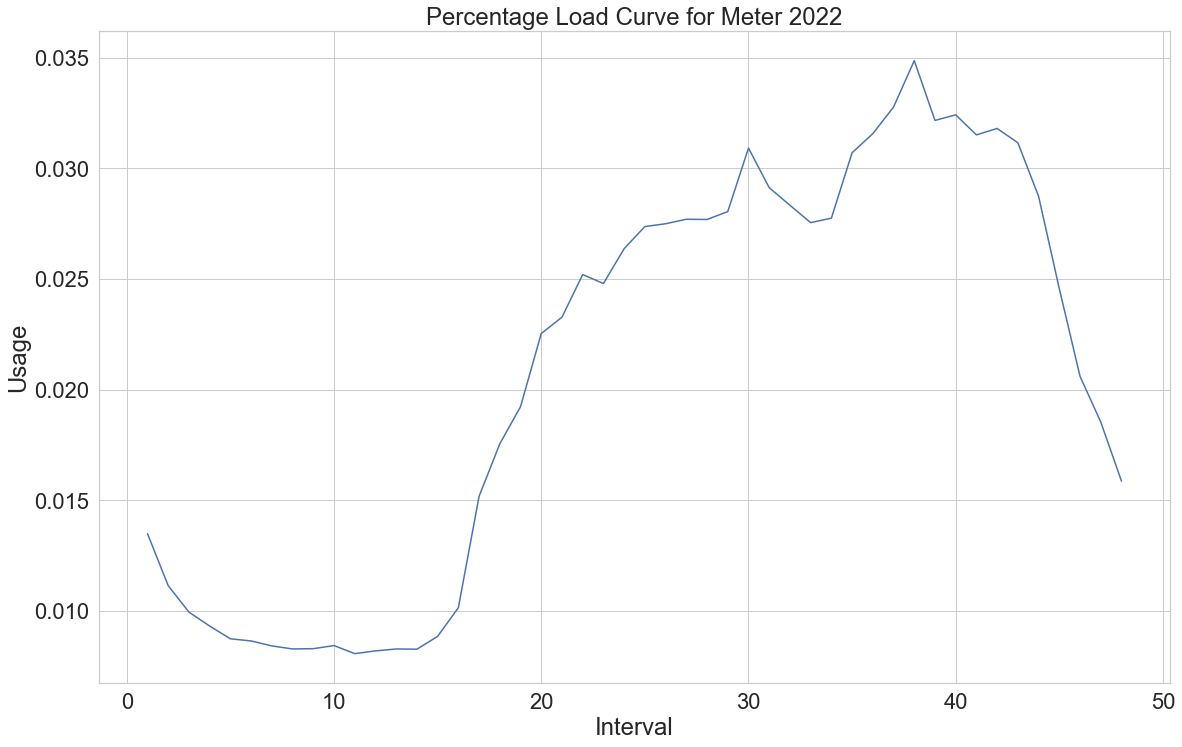

In [98]:
plot_avg_usage(usage_prop, 2022)

The figure above shows the average (mean) percentage of electricity consumed every 30 minute interval for a single customer. The 48 points along the x-axis represent the time in the day: one is the beginning of the day (12:30 AM) and point 48 is the end of the day (12:00 AM). The percentage load shape can be generaged for each of the consumers in the dataset. 

For this particular customer (2022), the consumption increased rapidly beginning point 16 (8:00 AM) and peaked around point 38 (7:00 PM). Consuption decreased significantly starting at interval 43 (9:30 PM).

The load shape summarizes energy consumption for weekdays only for a period of one and a half years. 

## 2. Modeling: Cluster analysis

Clustering algorithms are often used to find patterns and/or structure in unlabeled datasets. The function of clustering in this project is to identify homogeneous groups of electricity consumers so that the consumers within each cluster may be categorized as to whether they are a good candidate for a DR program.

The literature has shown that **Gaussian Mixture Models** (GMM) can be effective in segmenting electricity customers based on consumption profiles.

#### GMM Clustering

CPU times: user 1min 15s, sys: 17.7 s, total: 1min 33s
Wall time: 11.6 s


Text(0.5, 0, 'n_components')

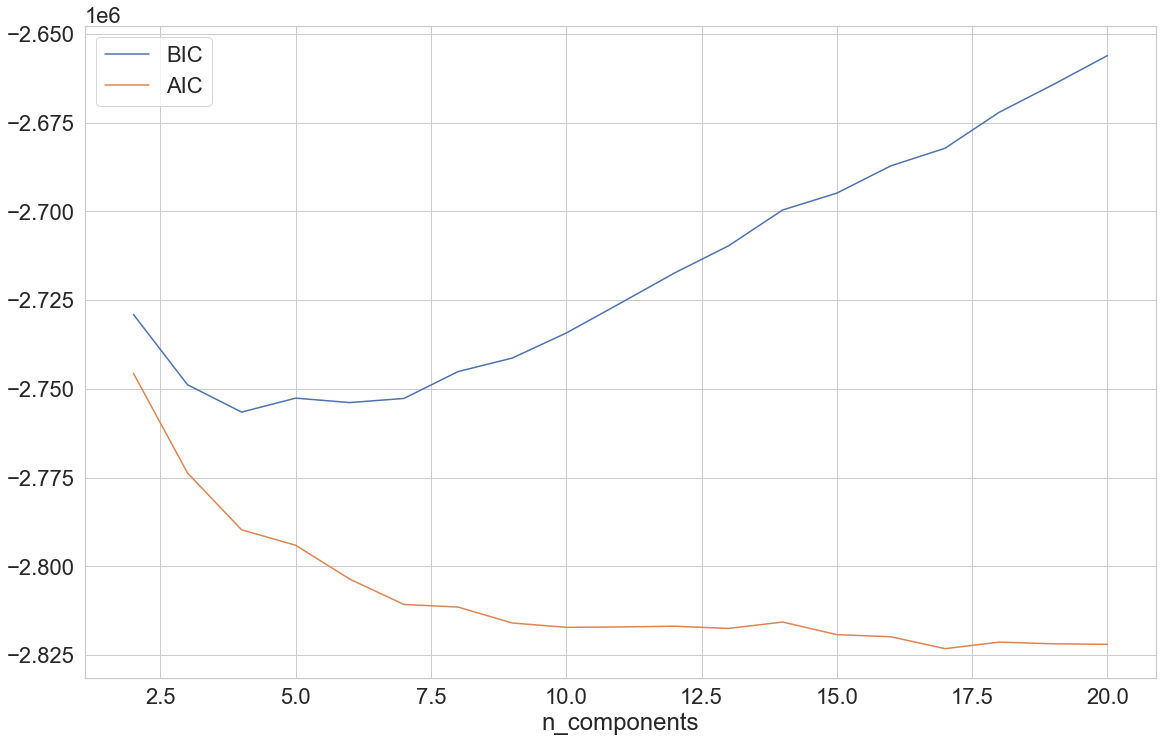

In [103]:
%%time

from sklearn.mixture import GaussianMixture
n_components = np.arange(2, 21)
models = [GaussianMixture(n, covariance_type='full', random_state=0).fit(usage_prop)
          for n in n_components]

plt.plot(n_components, [m.bic(usage_prop) for m in models], label='BIC')
plt.plot(n_components, [m.aic(usage_prop) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

Comparing the `AIC` and `BIC` metrics against the number of components provides clarity into the best choice for the number of clusters for this dataset. `BIC` suggests between four and six clusters as optimal, whereas `AIC` suggests using six clusters as optimal. 

Below, the Silhouette metric is used to evaluate how defined the clusters are. The Silhouette scores suggest that five clusters may be optimal for this dataset. 

In [104]:
from sklearn.metrics import silhouette_score

scores = []
for n in n_components:
    labels = GaussianMixture(n, covariance_type='full', random_state=0).fit(usage_prop).predict(usage_prop)
    silhouette_avg = silhouette_score(usage_prop, labels)
    print('Silhouette Score for %i Clusters: %0.4f' % (n, silhouette_avg))
    scores.append(silhouette_avg)

Silhouette Score for 2 Clusters: 0.2554
Silhouette Score for 3 Clusters: 0.1709
Silhouette Score for 4 Clusters: 0.0750
Silhouette Score for 5 Clusters: 0.0862
Silhouette Score for 6 Clusters: 0.0506
Silhouette Score for 7 Clusters: 0.0404
Silhouette Score for 8 Clusters: 0.0506
Silhouette Score for 9 Clusters: 0.0489
Silhouette Score for 10 Clusters: 0.0418
Silhouette Score for 11 Clusters: 0.0400
Silhouette Score for 12 Clusters: 0.0377
Silhouette Score for 13 Clusters: 0.0289
Silhouette Score for 14 Clusters: 0.0261
Silhouette Score for 15 Clusters: 0.0142
Silhouette Score for 16 Clusters: 0.0216
Silhouette Score for 17 Clusters: -0.0070
Silhouette Score for 18 Clusters: 0.0044
Silhouette Score for 19 Clusters: -0.0008
Silhouette Score for 20 Clusters: 0.0126


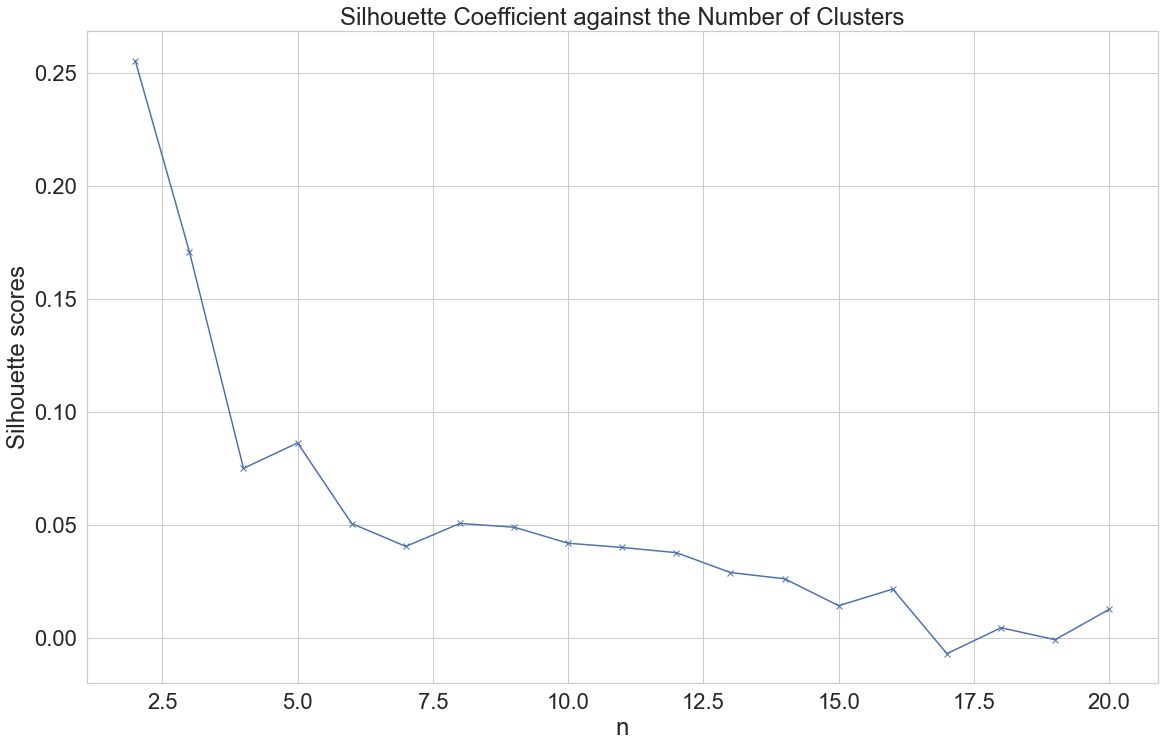

In [91]:
plt.plot(n_components, scores, 'bx-')
plt.xlabel('n')
plt.ylabel('Silhouette scores')
plt.title('Silhouette Coefficient against the Number of Clusters')
plt.show()

Given the information in the evaluation metrics (including AIC, BIC, and Silhouette Coefficient), n = 5 clusters has been chosen for further evaluation.

#### Cluster Evaluation

In [149]:
usage_prop["cluster"] = GaussianMixture(5, covariance_type='full', random_state=0).fit(usage_prop).predict(usage_prop)

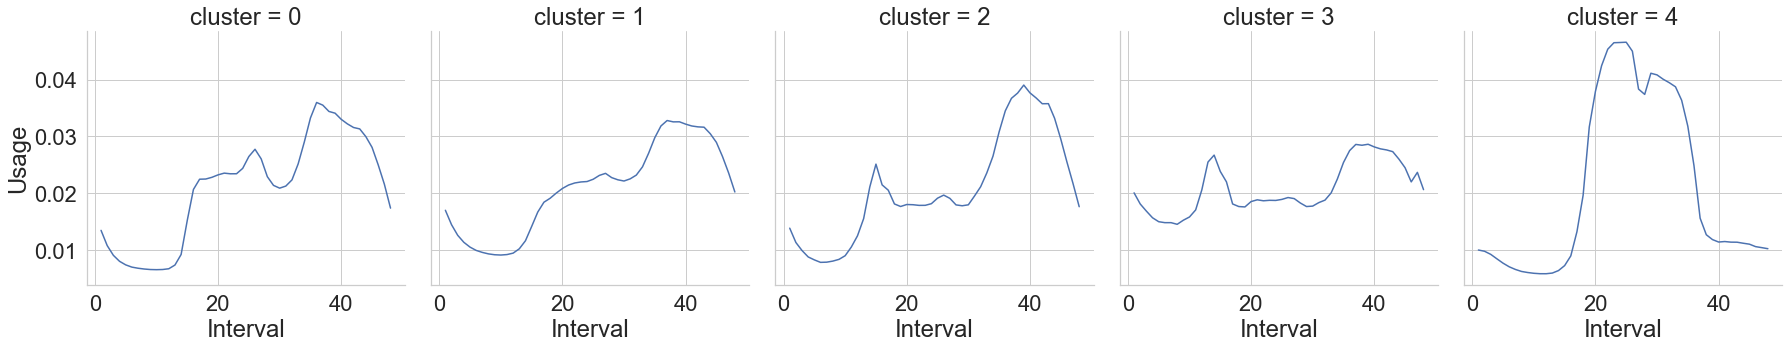

In [150]:
tmp = pd.melt(usage_prop.groupby("cluster").mean().reset_index(), id_vars=['cluster'], value_name='avg_usage')
ax = sns.relplot(data=tmp, x='timeCode', y='avg_usage', col='cluster', kind='line')
ax.set(xlabel='Interval', ylabel='Usage')
plt.show()

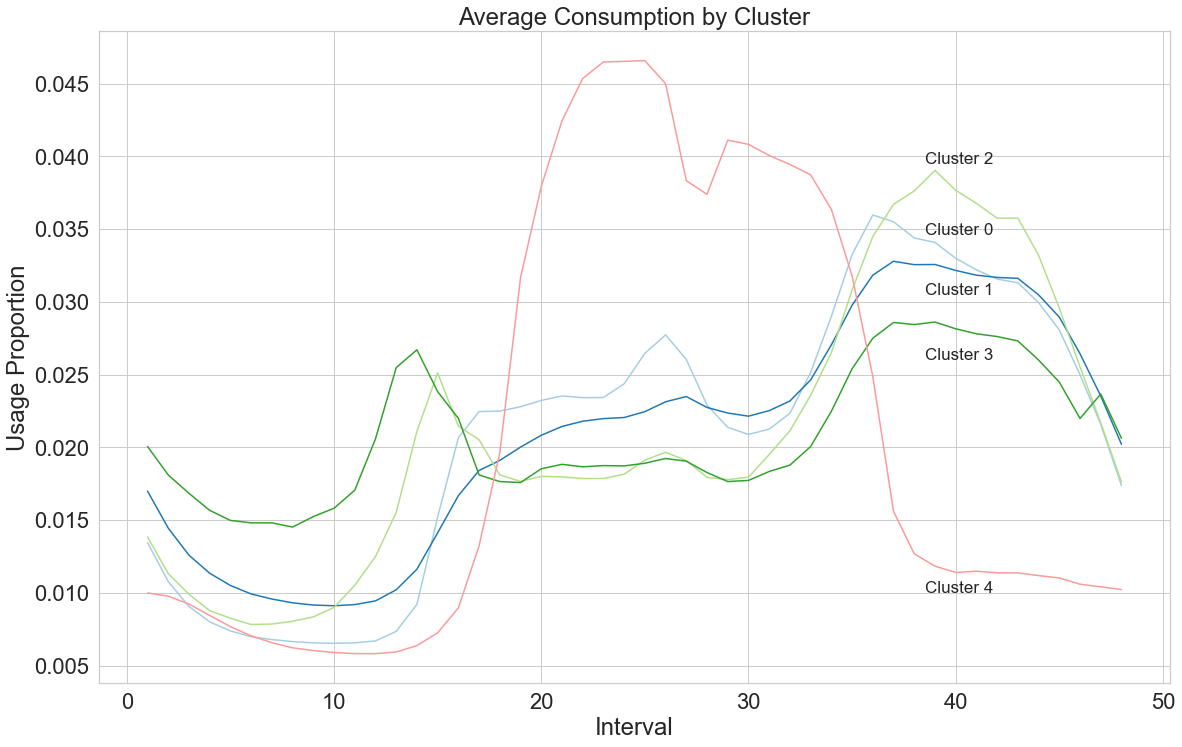

In [185]:
tmp = pd.melt(usage_prop.groupby("cluster").mean().reset_index(), id_vars=['cluster'], value_name='avg_usage')
ax = sns.lineplot(data=tmp, x='timeCode', y='avg_usage', hue='cluster', palette="Paired", legend=False)
ax.set(xlabel='Interval', ylabel='Usage Proportion', title="Average Consumption by Cluster")

ax.text(38.5, 0.01, "Cluster 4", size=17)
ax.text(38.5, 0.026, "Cluster 3", size=17)
ax.text(38.5, 0.0305, "Cluster 1", size=17)
ax.text(38.5, 0.0346, "Cluster 0", size=17)
ax.text(38.5, 0.0395, "Cluster 2", size=17)

plt.show()

The figure above shows the mean electricity consumption by cluster. 
* Although the data is not labeled, we know from the description that the data includes both commercial and residential customers. Cluster 4 customers use most of their electricity during the day, and are likely commercial customers. 
* The load curves for clusters 0-3 take relatively similar shapes, but the quantities of usage at any given time are distinct. For example, clusers 2 and 3 usage increases sharply starting around 8:00 AM; however, cluster 3 morning usage is significantly higher while cluster 2 evening usage is much higher. 

The utility can use the information given to segment its customers for better  service outcomes and customer relationship management. However, our goal is to identify clusters with a high potential as targets of DR campaigns. 

The literature shows that segments with daytime and evening peaks have a high potential for being DR targets, while those with dual peaks -- morning and evening -- have a low potential as DR targets. With this information in mind, **clusters 0 and 1 have the highest potential as DR targets**. 

In [257]:
# New object containing each customer ID and assigned cluster
cusomter_cluster = usage_prop["cluster"]

#### Peak time

**Peak time** hours fluxuate based on region, season, weather, and other factors. (For example, OGE currently defines peak hours as Monday-Friday, 2:00 - 7:00PM from June 1st to September 30th.) For the purpose of demonstrating this concept, I will define peak time arbitrarily as when the average electricity usage is at least 25% higher than it should be in the case of an evenly distributed usage (regardless of season, weather, etc). By defining peak time this way, we identify that most intervals that fall into peak time occurr in the evening between the hours of  hours of peak usage as occurring between intervals 33 (ending at 4:30 PM) and 43 (ending at 9:30 PM), inclusive.

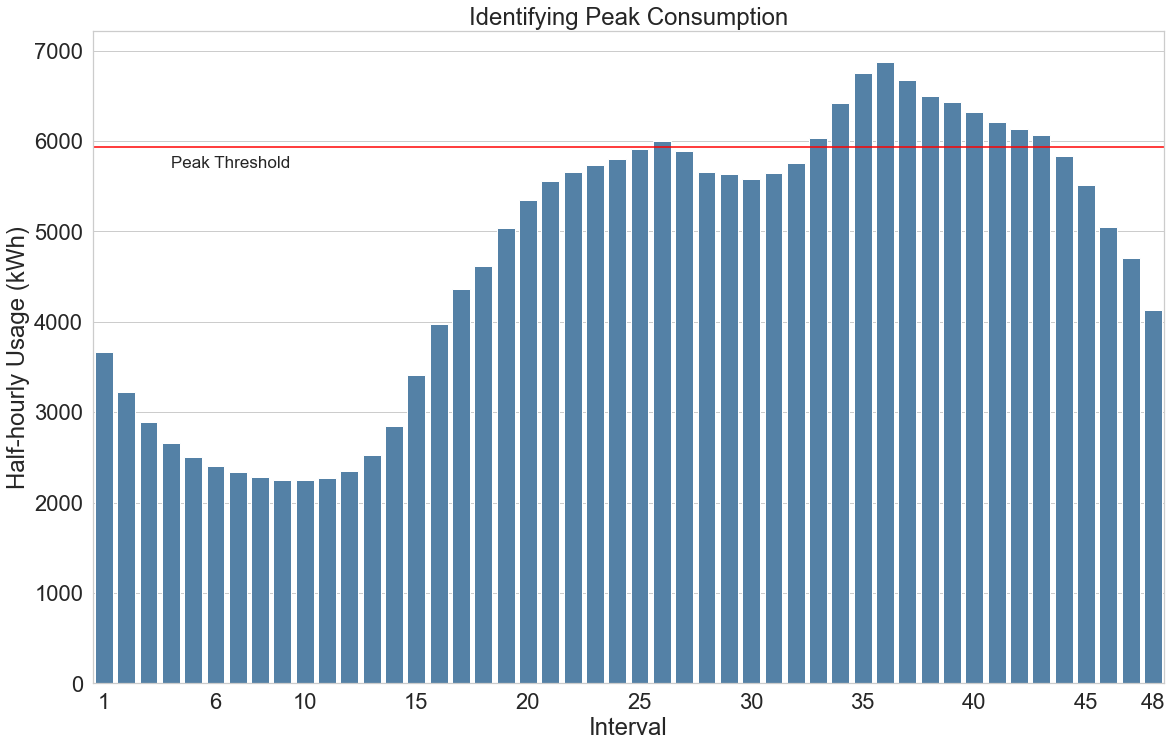

In [340]:
ax = sns.barplot(data=df_avg.sum().to_frame(name='Consumption').reset_index(), x='timeCode', y='Consumption', color='steelblue')
ax.set(xlabel='Interval', ylabel='Half-hourly Usage (kWh)', title="Identifying Peak Consumption")
ax.axhline(df_avg.sum().sum() / 48 * 1.25, color="red")

ax.text(3, 5700, "Peak Threshold", size=17)

plt.xticks([0, 5, 9, 14, 19, 24, 29, 34, 39, 44, 47])

plt.show()

In [260]:
# Merge the customer usage with cluster assignment
cust_avg_usage_with_cluster = df_avg.merge(cusomter_cluster.to_frame(), left_index=True, right_index=True)

In [290]:
def plot_peak(cluster):
    tmp = pd.melt(cust_avg_usage_with_cluster.groupby("cluster").mean().reset_index(), id_vars=['cluster'], value_name='avg_usage')
    ax = sns.lineplot(data=tmp[tmp.cluster==cluster], x='variable', y='avg_usage', hue='cluster', palette="Paired", legend=False)
    ax.set(xlabel='Interval', ylabel='Half-hourly Usage (kWh)', title="Identifying Consumption by Cluster " + str(cluster))

    plt.show()

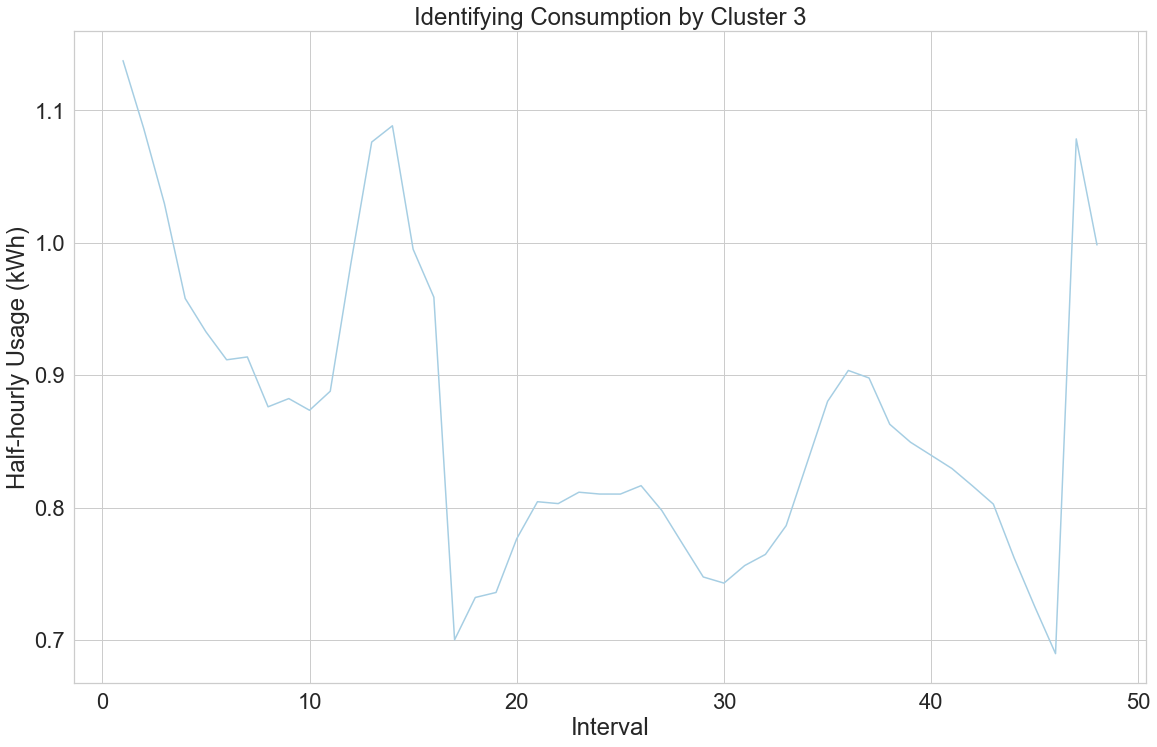

In [314]:
plot_peak(3) # Plotting the load graph for each cluster

Calculate the proportion of usage per interal. Good candidates are those who use more electricity "off-peak" than they should in the case of an evenly distributed usage. Peak time accounts for 25% of the day (12/48 intervals). Therefore, those who use less than 25% of their electricity during peak hours are good candidates for DR. 

In this case only cluster 4 qualifies as optimal candidates for DR. Cluster 3 might also be considered due to the relatively low peak usage.


In [365]:
tbl = pd.DataFrame({'Peak Usage %':[35.5, 33.8, 37.5, 29.2, 21.7]})
tbl.index.name = 'Cluster'
tbl

,Peak Usage %
Cluster,
0,35.5
1,33.8
2,37.5
3,29.2
4,21.7


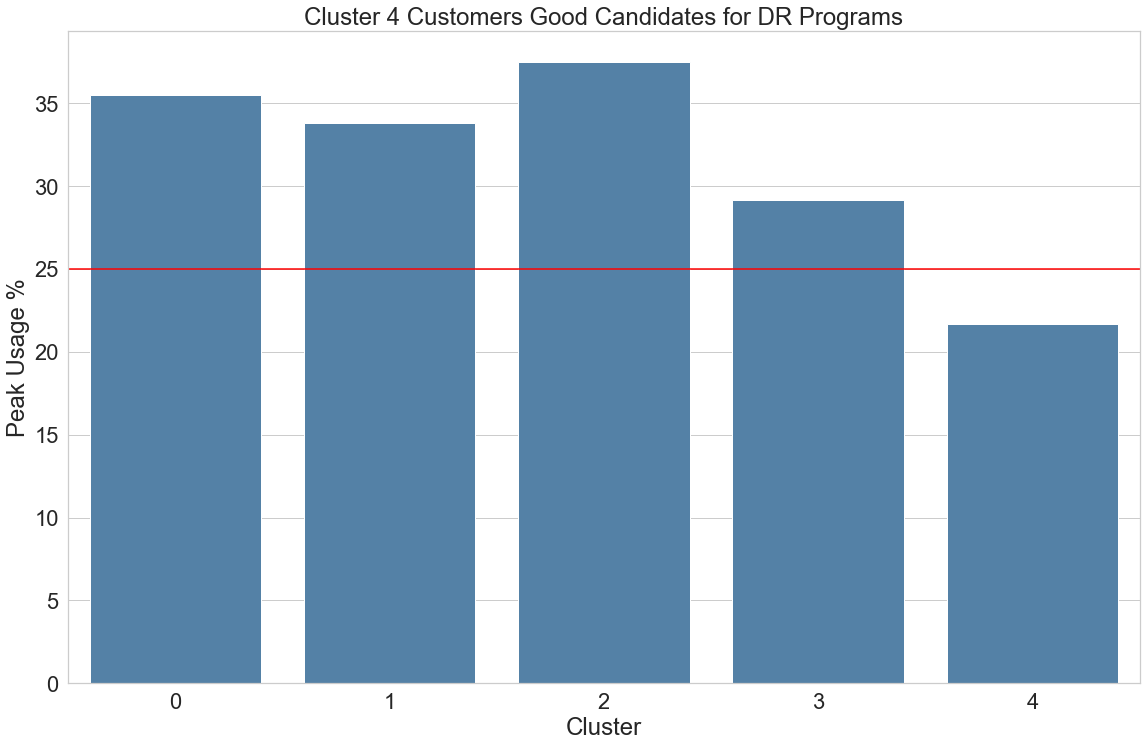

In [370]:
ax = sns.barplot(x=tbl.index, y=tbl['Peak Usage %'], color='steelblue')
ax.set(title='Cluster 4 Customers Good Candidates for DR Programs')
ax.axhline(25, color="red")
plt.show()

## 3. Modeling: Customer classification (prediction)

Customers have been clustered into five segments, and cluster 4 customers have been identified as most likely to enroll in DR programs based on usage profile. The last step in this project is predicting whether customers are likely to be good candidates for DR based on usage history. In this step:
1. Add data labels; cluster 4 customers are given the positive class.
2. Train a predictive model (classification).

#### Add labels

In [373]:
usage_prop["Offer"] = np.where(usage_prop.cluster==4, 1, 0)
usage_prop.drop('cluster', axis=1, inplace=True)
usage_prop.head()

timeCode,1,2,3,4,5,6,7,8,9,10,...,40,41,42,43,44,45,46,47,48,Offer
meterId,,,,,,,,,,,,,,,,,,,,,
1000,0.009831,0.006633,0.005496,0.005777,0.005269,0.005213,0.005184,0.005197,0.005314,0.004935,...,0.044685,0.042579,0.042502,0.035672,0.034085,0.032759,0.027904,0.021806,0.016329,0
1001,0.021131,0.021425,0.020928,0.020571,0.020847,0.020516,0.020150,0.020460,0.021116,0.020240,...,0.020512,0.021481,0.020988,0.020957,0.021425,0.021323,0.021248,0.020669,0.019947,0
1002,0.018452,0.012740,0.009479,0.008216,0.007359,0.007105,0.006999,0.007051,0.006743,0.007094,...,0.028863,0.031313,0.032993,0.035704,0.035570,0.035960,0.035620,0.034086,0.027589,0
1003,0.018708,0.017658,0.016445,0.014757,0.014121,0.013317,0.012589,0.012026,0.012650,0.015951,...,0.031650,0.029268,0.028475,0.028219,0.027320,0.026957,0.024453,0.022351,0.020283,0
1004,0.020893,0.018324,0.015967,0.014058,0.012766,0.011614,0.010476,0.009385,0.008719,0.008051,...,0.045097,0.040437,0.040053,0.038586,0.038595,0.035606,0.032349,0.026688,0.023691,0


In [375]:
usage_prop.Offer.value_counts(normalize=True) # only about 3% of existing customers are in cluster 4

0    0.961293
1    0.038707
Name: Offer, dtype: float64

#### Data splitting

In [378]:
# Split the features and response variables
X = usage_prop.drop('Offer', axis=1)
y = usage_prop['Offer']

In [380]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

#### Model building: Random Forest

In [383]:
%%time
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# define the hyperparameters
params = {'n_estimators': [10, 25, 50, 100, 200, 300, 400, 500],
          'max_features': ['sqrt', 'log2'],
          'max_depth': [2, 3, 5, 10, 20, 40, 80],
          'criterion': ["gini", "entropy"]
}

gridSearch = RandomizedSearchCV(RandomForestClassifier(), 
                                n_iter=50,
                                param_distributions=params, 
                                cv=5, n_jobs=-1, verbose=1, scoring="recall")

gridSearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   39.3s
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.1min finished


CPU times: user 1.47 s, sys: 217 ms, total: 1.69 s
Wall time: 1min 7s


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 10, 20, 40, 80],
                                        'max_features': ['sqrt', 'log2'],
                                        'n_estimators': [10, 25, 50, 100, 200,
                                                         300, 400, 500]},
                   scoring='recall', verbose=1)

In [384]:
rfClf = gridSearch.best_estimator_
print(rfClf)

RandomForestClassifier(max_depth=20, max_features='sqrt', n_estimators=50)


#### Evaluate model performance

In [388]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix # import

In [390]:
def evaluate_model(classifier, X_train, y_train, X_val, y_val):
    print("Train Accuracy :", accuracy_score(y_train, classifier.predict(X_train)))
    print("Train Confusion Matrix:")
    print(confusion_matrix(y_train, classifier.predict(X_train)))
    print("-"*50)
    print("Test Accuracy :", accuracy_score(y_test, classifier.predict(X_test)))
    print("Test Precision :", precision_score(y_test, classifier.predict(X_test)))
    print("Test Recall :", recall_score(y_test, classifier.predict(X_test)))
    print("Test F1 :", f1_score(y_test, classifier.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_val, classifier.predict(X_test)))

In [391]:
evaluate_model(rfClf, X_train, y_train, X_test, y_test)

Train Accuracy : 0.9997927031509121
Train Confusion Matrix:
[[4637    0]
 [   1  186]]
--------------------------------------------------
Test Accuracy : 0.9850839030453697
Test Precision : 0.9130434782608695
Test Recall : 0.6774193548387096
Test F1 : 0.7777777777777777
Test Confusion Matrix:
[[1543    4]
 [  20   42]]


#### Performance

A **Random Forest** model was trained against the training data, then evaluated on the training and test datasets. The model performed well, correctly classifying test instances 98% of the time. **Precision** of 0.91 and **recall** of 0.67 are also indicators of a good performing model. Looking at the confusion matrix, the model misclassified 24 of the 1609 test instance. Most (20 of 24) of these misclassifications were false negatives. Any additional work to fine tune the model should be spent decreasing the false negative rate.

## 4. Conclusion

This project uses data-driven methodology to predict which customers are good candidates for Demand Response programs, first by finding usage-based clusters within our dataset of customer data, then by predicting (classifying) customers as good candidates. The results suggest that recruiting within a subpopulation that is more likely to enroll in DR programs improves the effectiveness of targeted marketing.

The main limitations include: 1) the use of a naive peak time definition, without incorporting location, time of year, etc., and 2) does not consider _prosumers_ - those customers who both consume and produce energy. 

This project was inspired by Martinez-Pabon, M., Eveleigh, T and Tanju, B. (2016). Smart meter data analytics for optimal customer selection in demand response programs. _Energy Procedia_(107) 49 – 59. 

References

1. Martinez-Pabon, M., Eveleigh, T and Tanju, B. (2016). Smart meter data analytics for optimal customer selection in demand response programs. _Energy Procedia_(107) 49 – 59. 
2. https://www.cpuc.ca.gov/industries-and-topics/electrical-energy/electric-costs/demand-response-dr
3. Commission for Energy Regulation (CER). (2012). CER Smart Metering Project - Electricity Customer Behaviour Trial, 2009-2010 [dataset]. 1st Edition. Irish Social Science Data Archive. SN: 0012-00. https://www.ucd.ie/issda/data/commissionforenergyregulationcer/.
4. VanderPlas, J. (2016). _Python Data Science Handbook_. O'Reilly Media, Inc. https://jakevdp.github.io/PythonDataScienceHandbook/. 